# Overview of most nengolib features

Aaron R. Voelker (February 3, 2018)

---

To install: **`pip install nengolib`**. For the complete documentation, see: https://arvoelke.github.io/nengolib-docs/.

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from nengolib_notebook_magic import *

import numpy as np
import nengo
import nengolib
from nengolib.signal import s, z

## 1) Quasi-Monte Carlo Sampling 


In [3]:
def plot_eval_encoders(module, n=200, m=2500):
    with module.Network() as model:
        x = nengo.Ensemble(n, 2, n_eval_points=m)
        
    with nengo.Simulator(model) as sim:
        scatter_kwargs = dict(lw=0.5, s=15, edgecolor='black')
        fig, ax = plt.subplots(1, 2, figsize=(16, 9))
        ax[0].set_title('Encoders')
        ax[0].scatter(*sim.data[x].encoders.T, **scatter_kwargs)
        ax[0].axis('equal')
        ax[1].set_title('Evaluation Points')
        ax[1].scatter(*sim.data[x].eval_points.T, **scatter_kwargs)
        ax[1].axis('equal')
        fig.show()

Let's look at the default distribution of encoders and evaluation points in Nengo. We'll use two dimensions for sake of visualization.

Building finished in 0:00:01.                                                   


c:\Users\Aaron\Anaconda2\lib\site-packages\matplotlib\figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


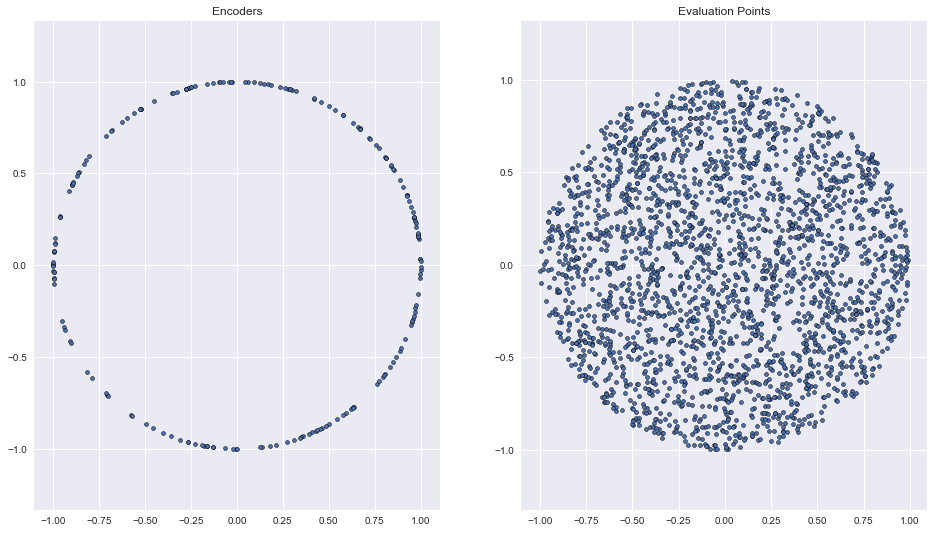

In [4]:
plot_eval_encoders(nengo)

Now let's try the exact same thing, but using `nengolib.Network()` instead of `nengo.Network()`.

Building finished in 0:00:01.                                                   


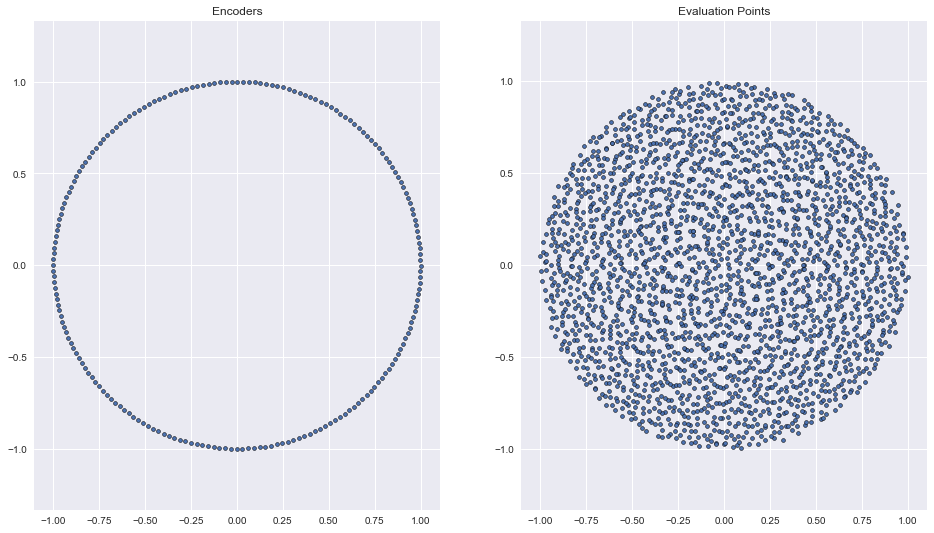

In [5]:
plot_eval_encoders(nengolib)

Both samples become more uniform. The number of sample points are the same, and so are the underlying distributions, but there are far fewer clumps and open spaces than there were for the default samples. In other words, the samples are more "scattered".

Quasi-Monte Carlo refers to the general approach of sampling some distribution, by using **dependent samples** rather than independent samples. This is with the aim of providing samples with an empirical distribution that is closer to the true underlying distribution.

Theory from **number-theoretic sequences** tells us that the number of evaluation points is effectively **squared** versus the defaults ([details](https://arvoelke.github.io/nengolib-docs/notebooks.research.sampling_high_dimensional_vectors.html)). The improvement for the encoders is much harder to measure theoretically, since it alters the tuning curves and thus depends on the function being computed. However, empirical results indicate that it at least improves the identity function.

Takeaway: `nengolib.Network()` is a drop-in replacement for `nengo.Network()` that automatically substitutes the default distributions:
 - `nengo.dists.UniformHypersphere(surface=True)` for `nengolib.stats.sphere`, and
 - `nengo.dists.UniformHypersphere(surface=False)` for `nengolib.stats.ball`
 
This should work right out of the box, and should very rarely (if ever?) make things worse on average.

Extra:
 - [`nengolib.stats.cube`](https://arvoelke.github.io/nengolib-docs/nengolib.stats.ScatteredCube.html#nengolib.stats.cube) gives the same nicely scattered distribution on the hypercube.
 - [`nengolib.stats.spherical_transform`](https://arvoelke.github.io/nengolib-docs/nengolib.stats.spherical_transform.html#nengolib.stats.spherical_transform) gives a way to uniformly map between spheres, balls, and cubes.
 - [`nengolib.stats.random_orthogonal`](https://arvoelke.github.io/nengolib-docs/nengolib.stats.random_orthogonal.html#nengolib.stats.random_orthogonal) gives a uniformly random rotation matrix.

## 2) Leech Lattice (Kissing Points)

In [6]:
def plot_similarities(title, V, k=1000, bins=99):
    s = V[np.random.choice(len(V), k)].dot(
        V[np.random.choice(len(V), k)].T).flatten()
    plt.figure(figsize=(18, 8))
    plt.title(title)
    plt.hist(s, bins=bins, normed=True)
    plt.ylabel("Density")
    plt.xlabel(r"$u_i \cdot u_j$")
    plt.xlim(-1, 1)
    plt.show()
    #return s

For context, let's generate a random vocabulary ($V$) from the $23$-sphere (i.e., the surface of the $24$-dimensional ball), and then take the dot-product between random pairs of semantic pointers from $V$.

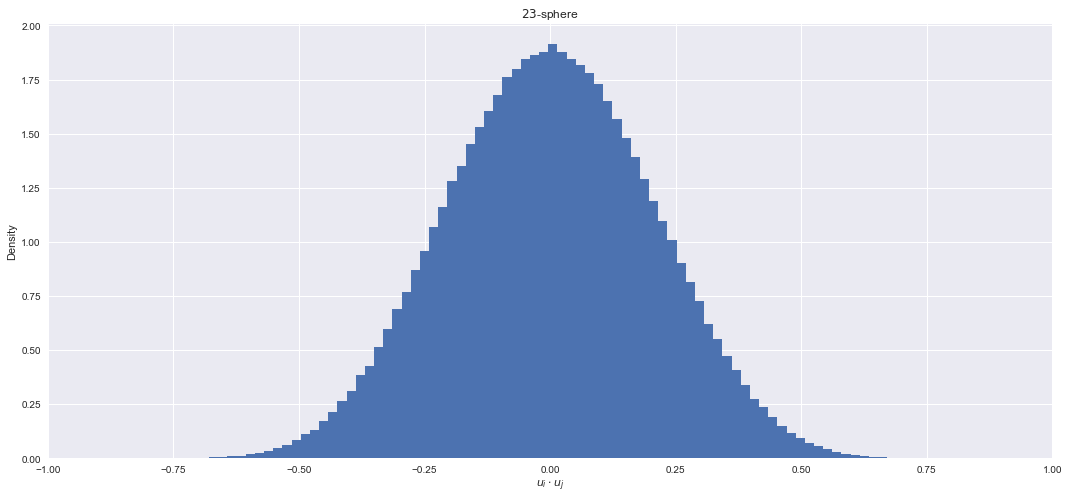

In [7]:
m = 196560
V = nengo.dists.UniformHypersphere(surface=True).sample(m, 24)
plot_similarities("$23$-sphere", V)

These similarities are distributed according to `nengo.dists.CosineSimilarity(24)`.

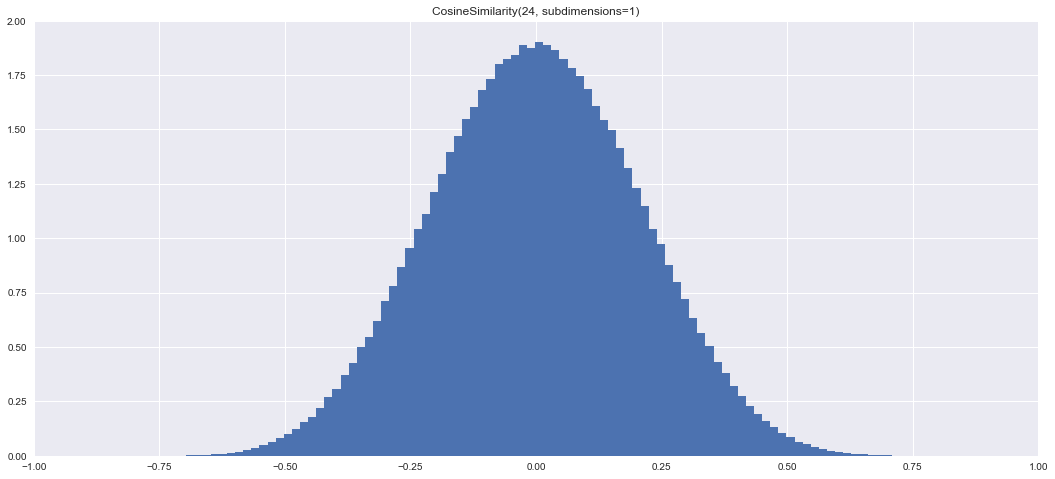

In [8]:
dist = nengo.dists.CosineSimilarity(24)
plt.figure(figsize=(18, 8))
plt.title(repr(dist))
plt.hist(dist.sample(1000000), bins=99, normed=True)
plt.xlim(-1, 1)
plt.show()

Most semantic pointers are nearly orthogonal to one another, but the distribution is long-tailed with many vectors ending up fairly close to one another with constant probability. Moreover, since many vectors are far apart, they are not efficiently making use of the available space (this is again related to the problem with Monte Carlo sampling). This can be problematic in situations where we would like to stay below some maximum similarity (we would like the vocabulary to be uniformly spread around).

Notice that Quasi-Monte Carlo sampling does not help with this problem, because it does not alter the distribution!

Instead, to address this, we turn towards [`nengolib.stats.leech_kissing`](https://arvoelke.github.io/nengolib-docs/nengolib.stats.leech_kissing.html#nengolib.stats.leech_kissing) for the "kissing points" from the Leech lattice; a set of $196,560$ vectors, all on the $23$-sphere, and optimally spaced apart.

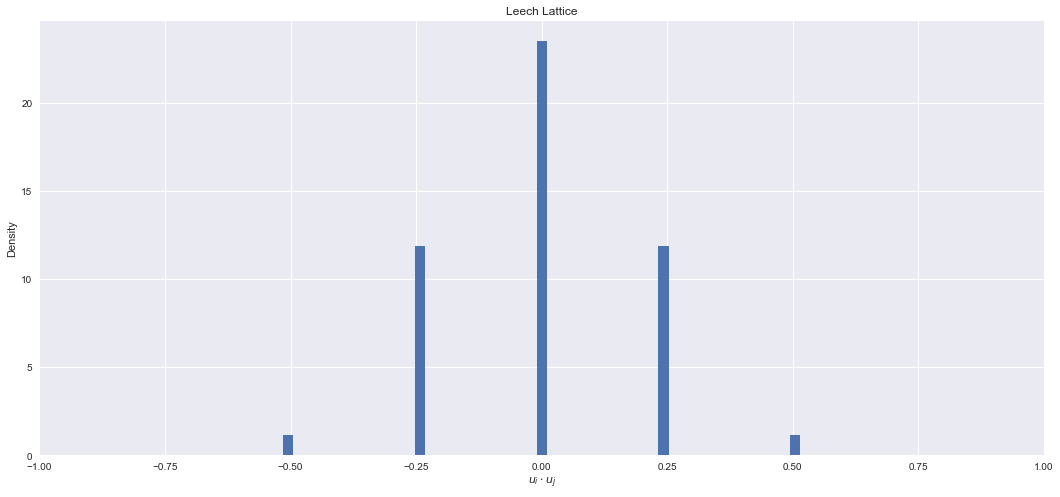

In [9]:
V = nengolib.stats.leech_kissing()
assert V.shape == (m, 24)
_ = plot_similarities("Leech Lattice", V)

Now every semantic pointer is at least $60$° apart from every other vector in the same vocabulary!

To see why this is useful, let's ask `nengo.spa.Vocabulary` to generate a vocabulary with the exact same dimension and `max_similarity`.

In [10]:
V = nengo.spa.Vocabulary(24, max_similarity=0.5)

for i in range(m):
    p = V.create_pointer(attempts=1000)
    if i > 0 and np.max(V.vectors.dot(p.v)) > 0.5:
        break
    V.add("V%d" % i, p)

print("%s / %s (%.2f%%)" % (len(V.vectors), m, 100.0 * len(V.vectors) / m))

866 / 196560 (0.44%)


c:\Users\Aaron\Anaconda2\lib\site-packages\nengo\spa\vocab.py:114: UserWarning: Could not create a semantic pointer with max_similarity=0.50 (D=24, M=866)
  len(self.pointers)))


Even with a large number of attempts to generate each pointer (e.g., $1000$, which is $10$ times the default), it can still only find a small portion of vectors (i.e., less than $1000$, or less than $1$ percent) before giving up. On the other hand, the leech lattice finds all $~200,000$ vectors extremely quickly, and these are the best such vectors.

For your information, the leech lattice is derived from the _Golay Code_, a perfect linear error-correcting code consisting of $4096$ binary codewords that all have a Hamming distance of at least $7$ from one another.

Takeaway: using uniform distributions to sample vocabularies can make tasks exponentially more difficult than using "structured distributions".

## 3) Unified Language for Linear Time-Invariant (LTI) Systems

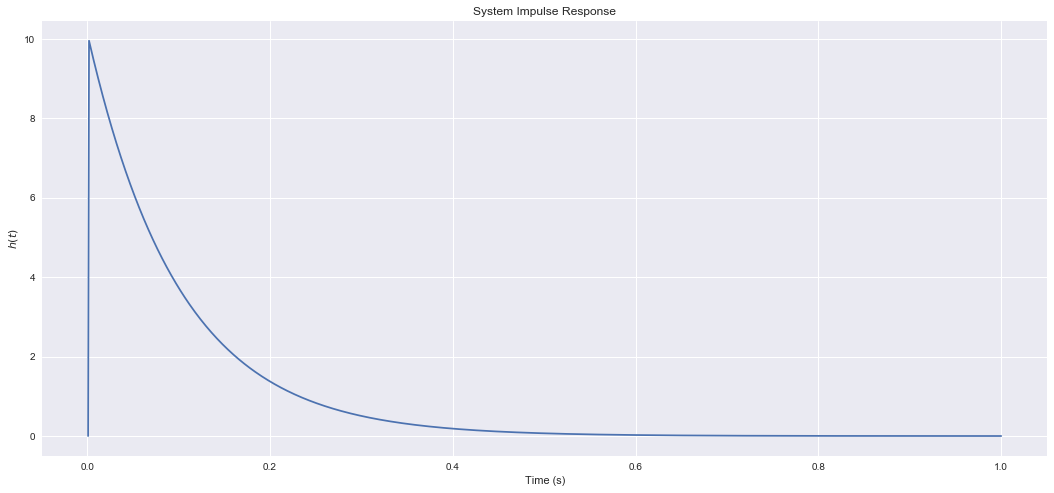

In [11]:
sys = nengolib.Lowpass(0.1)

plt.figure(figsize=(18, 8))
plt.title("System Impulse Response")
plt.plot(sys.ntrange(1000), nengolib.signal.shift(sys.impulse(1000)))
plt.xlabel("Time (s)")
plt.ylabel("$h(t)$")
plt.show()

This system is equivalent to `nengo.Lowpass`, and can be used in the same ways (they both derive the same base object in Nengo):
 - As an argument to `Connection` or `Probe`.
 - The `.filt` method applies the synapse to some input signal.
 - The `.evaluate` method evaluates the frequency response.

In [12]:
assert sys == nengo.Lowpass(0.1)
assert isinstance(sys, nengo.synapses.Synapse)

Building finished in 0:00:01.                                                   


c:\users\aaron\ctn\nengolib\nengolib\signal\system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


Simulating finished in 0:00:01.                                                 


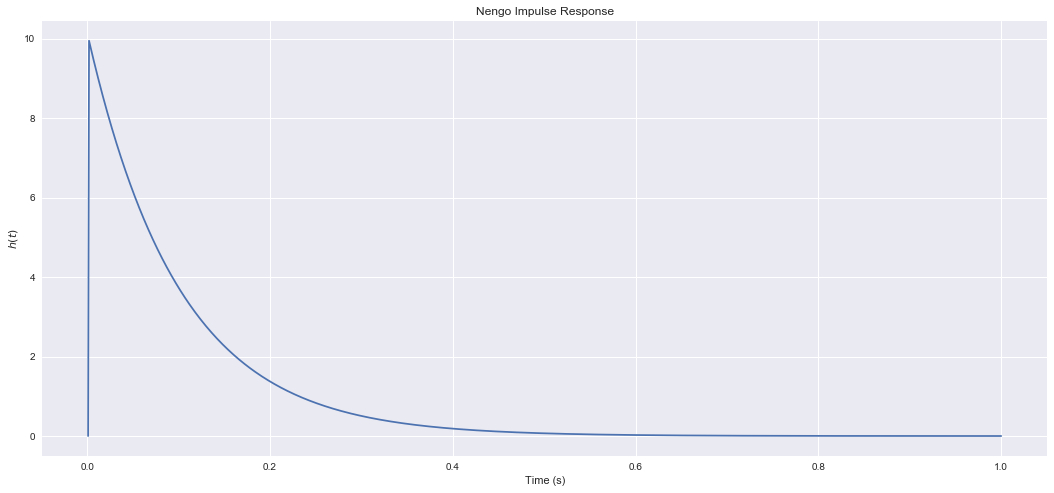

In [13]:
with nengolib.Network() as model:
    p = nengo.Probe(nengo.Node(output=lambda t: 1000 if t <= 1e-3 else 0), synapse=sys)

with nengo.Simulator(model) as sim:
    sim.run(1)

plt.figure(figsize=(18, 8))
plt.title("Nengo Impulse Response")
plt.plot(sim.trange(), sim.data[p])
plt.xlabel("Time (s)")
plt.ylabel("$h(t)$")
plt.show()

c:\Users\Aaron\Anaconda2\lib\site-packages\numpy\core\numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


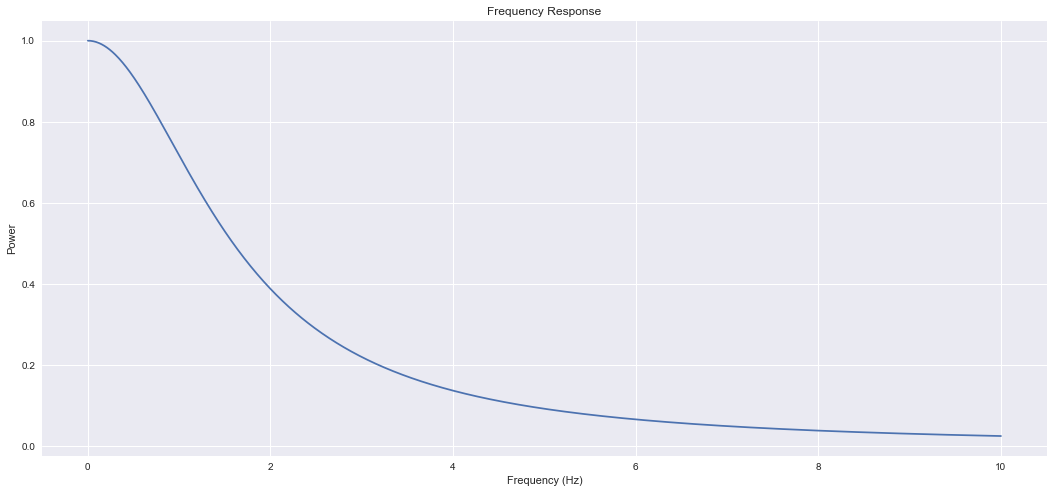

In [14]:
freqs = np.linspace(0, 10, 1000)

plt.figure(figsize=(18, 8))
plt.title("Frequency Response")
plt.plot(freqs, sys.evaluate(freqs))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.show()

LTI systems can take on many different equivalent forms. One of the most common and useful is the transfer function:

In [15]:
latex_tf(sys)

$H(s) = \frac{1}{0.1 s + 1}$

We can also see the state-space representation:

$$\dot{x}(t) = Ax(t) + Bu(t)$$
$$y(t) = Cx(t) + Du(t)$$

where the dimension of $x(t)$ corresponds to the degree of the denominator polynomial.

In [16]:
print(sys.ss)

(array([[-10.]]), array([[ 1.]]), array([[ 10.]]), array([[ 0.]]))


There is also the zero-pole-gain form (`sys.zpk`), but it isn't informative for first-order systems. To create a system, the `nengolib.signal.LinearSystem` type accepts any of these formats -- as well as any Nengo synapse -- in its constructor (see [documentation](https://arvoelke.github.io/nengolib-docs/types.html#linear_system_like) for details).

### Manipulation

The `s` and `z` objects are special linear systems that act as building blocks for higher-order LTI systems. 

The integrator is just $H(s) = \frac{1}{s}$. Here's an example of how we can easily integrate a cosine wave.

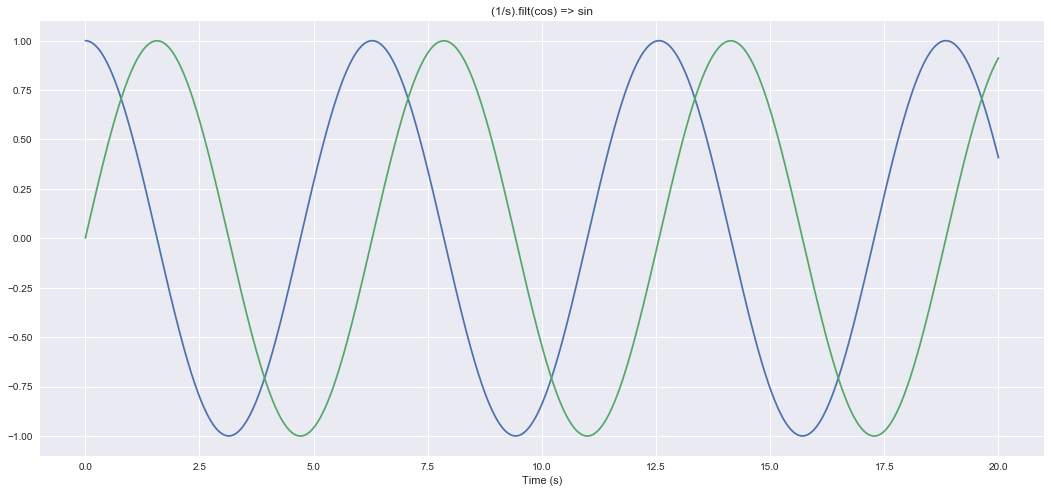

In [17]:
t = s.ntrange(20000)
u = np.cos(t)
y = (1/s).filt(u)

plt.figure(figsize=(18, 8))
plt.title("(1/s).filt(cos) => sin")
plt.plot(t, u, label="u(t)")
plt.plot(t, y, label="y(t)")
plt.xlabel("Time (s)")
plt.show()

The `z` operator is a discrete shift by one time-step.

c:\users\aaron\ctn\nengolib\nengolib\signal\system.py:213: UserWarning: Synapse ((num=[ 1.  -0.5  0.   2.   0.5], den=[ 1.  0.  0.  0.  0.], analog=False)) has extra delay due to passthrough (https://github.com/nengo/nengo/issues/938).
  "(https://github.com/nengo/nengo/issues/938)." % sys)


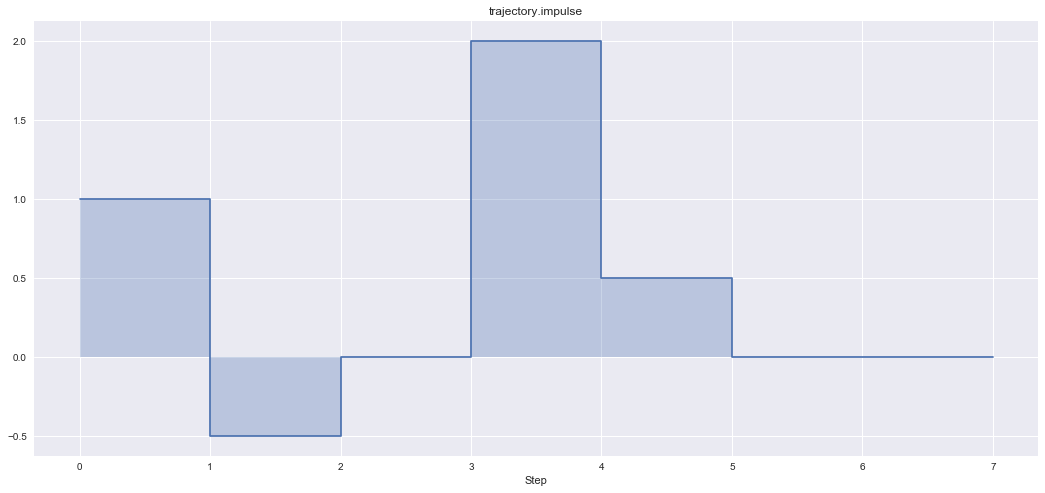

$H(z) = \frac{ z^4 + -0.5 z^3 + 2 z + 0.5}{ z^4}$

In [18]:
trajectory = 1 - .5/z + 2/z**3 + .5/z**4

t = np.arange(8)
y = trajectory.impulse(len(t))

plt.figure(figsize=(18, 8))
plt.title("trajectory.impulse")
plt.step(t, y, where='post')
plt.fill_between(t, np.zeros_like(y), y, step='post', alpha=.3)
plt.xticks(t)
plt.xlabel("Step")
plt.show()

latex_tf(trajectory)

Higher-order synapses may be constructed by adding/multiplying/dividing/etc. these basic building blocks together, or even other LTI systems together!

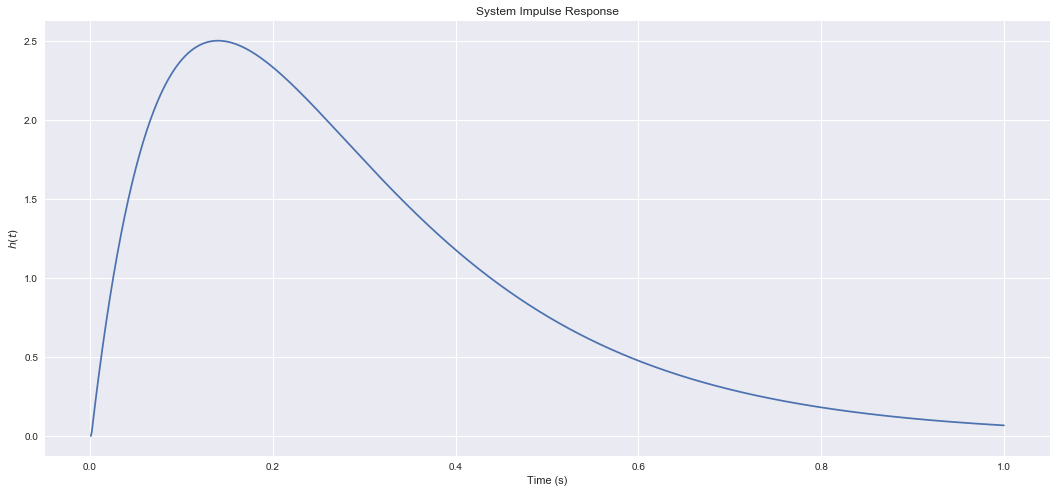

$H(s) = \frac{1}{0.02 s^2 + 0.3 s + 1}$

In [19]:
sys = 1 / ((0.1*s + 1)*(0.2*s + 1))
assert sys == nengolib.Lowpass(0.1) * nengolib.Lowpass(0.2)

plt.figure(figsize=(18, 8))
plt.title("System Impulse Response")
plt.plot(sys.ntrange(1000), nengolib.signal.shift(sys.impulse(1000)))
plt.xlabel("Time (s)")
plt.ylabel("$h(t)$")
plt.show()

latex_tf(sys)

### Analog $\leftrightarrow$ Digital

Lastly, we can switch between continuous and discrete representations of linear systems using [`nengolib.signal.cont2discrete`](https://arvoelke.github.io/nengolib-docs/nengolib.signal.cont2discrete.html#nengolib.signal.cont2discrete) and [`nengolib.signal.discrete2cont`](https://arvoelke.github.io/nengolib-docs/nengolib.signal.discrete2cont.html#nengolib.signal.discrete2cont), create digital systems by passing `analog=False` to `LinearSystem`, and manipulate any digital systems in the same way as analog. Everything is intended to "just work" regardless of domain.

Note that whenever it comes time to use an analog system (i.e., as a synapse in a digital simulation, to find its impulse response, or to filter some input), it is automatically discretized using ZOH.

## 4) Collection of Linear Systems

See [`nengolib.synapses`](https://arvoelke.github.io/nengolib-docs/nengolib.synapses.html) for a collection of analog and digital LTI systems. Usually these are used as synapses, but, again, there is no difference between a linear system and a linear synapse. As far as nengolib is concerned, these are just two different contexts for the same object.

For example, a pure delay in the digital domain is simply `z**(-k)`, where `k` is the number of time-steps. [`nengolib.synapses.PadeDelay`](https://arvoelke.github.io/nengolib-docs/nengolib.synapses.PadeDelay.html#nengolib.synapses.PadeDelay) gives the "best" finite-dimensional continuous-time approximation of this infinite-order system. 

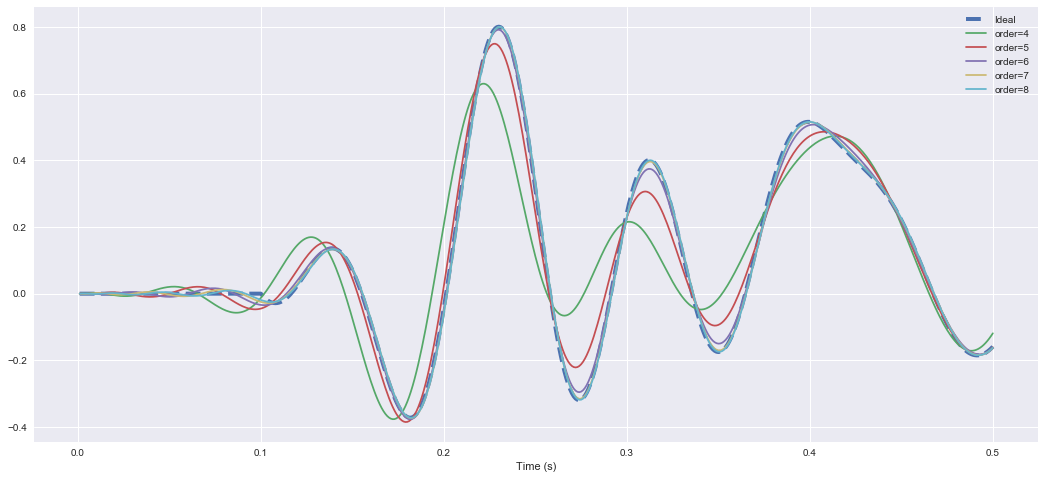

In [20]:
process = nengo.processes.WhiteSignal(10., high=15, y0=0)
u = process.run_steps(500)
t = process.ntrange(len(u))

plt.figure(figsize=(18, 8))
plt.plot(t, (z**-100).filt(u), linestyle='--', lw=4, label="Ideal")
for order in list(range(4, 9)):
    sys = nengolib.synapses.PadeDelay(0.1, order=order)
    assert len(sys) == order
    plt.plot(t, sys.filt(u), label="order=%s" % order)
plt.xlabel("Time (s)")
plt.legend()
plt.show()

All of these synapses can also be built up from the `s` and `z` operators, for example:

In [21]:
assert 1 / ((0.1*s + 1)*(0.2*s + 1)) == nengolib.synapses.DoubleExp(0.1, 0.2)
latex_tf(nengolib.synapses.DoubleExp(0.1, 0.2))

$H(s) = \frac{1}{0.02 s^2 + 0.3 s + 1}$

## 5) State-Space Realizations

Since the transfer function is unique, while the state-space representation is not, nengolib includes a toolbox of functions for manipulating state-space representations into various "realizations":
 - `sys.controllable`
 - `sys.observable`
 - [`nengolib.signal.Balanced(sys)`](https://arvoelke.github.io/nengolib-docs/nengolib.signal.Balanced.html#nengolib.signal.Balanced)
 - [`nengolib.signal.Hankel(sys)`](https://arvoelke.github.io/nengolib-docs/nengolib.signal.Hankel.html#nengolib.signal.Hankel)
 - [`nengolib.signal.L1Norm(sys)`](https://arvoelke.github.io/nengolib-docs/nengolib.signal.L1Norm.html#nengolib.signal.L1Norm)
 - [`nengolib.signal.H2Norm(sys)`](https://arvoelke.github.io/nengolib-docs/nengolib.signal.H2Norm.html#nengolib.signal.H2Norm)

Each of these representations can be understood as a linear transformation of the state-space. This can be useful as a way to balance the radius of each dimension, for instance.

There are many useful functions underlying these transformations as well, such as:
 - [`hsvd`](https://arvoelke.github.io/nengolib-docs/nengolib.signal.hsvd.html#nengolib.signal.hsvd) for computing the Hankel singular values of a linear system
 - [`control_gram`](https://arvoelke.github.io/nengolib-docs/nengolib.signal.control_gram.html#nengolib.signal.control_gram) for computing the controllability Gramiam.
 - [`observe_gram`](https://arvoelke.github.io/nengolib-docs/nengolib.signal.observe_gram.html#nengolib.signal.observe_gram) for computing the observability Gramiam.
 - etc...

We can also reduce linear systems by balancing and/or intelligently removing dimensions ([details](https://arvoelke.github.io/nengolib-docs/notebooks.research.linear_model_reduction.html)):
 - [`nengolib.signal.modred(sys)`](https://arvoelke.github.io/nengolib-docs/nengolib.signal.modred.html#nengolib.signal.modred)
 - [`nengolib.signal.balred(sys)`](https://arvoelke.github.io/nengolib-docs/nengolib.signal.balred.html#nengolib.signal.balred)
 - [`pole_zero_cancel(sys)`](https://arvoelke.github.io/nengolib-docs/nengolib.signal.pole_zero_cancel.html#nengolib.signal.pole_zero_cancel)

## 6) Accurate Linear Networks

The [`nengolib.networks.LinearNetwork`](https://arvoelke.github.io/nengolib-docs/nengolib.networks.LinearNetwork.html#nengolib.networks.LinearNetwork) class is a Nengo network that implements a given linear system using Principle 3, plus:
 - automatic state-space realizations
 - mapping onto other synapses (not just lowpass)
 - correctly accounting for the simulation time-step
 
Some details on the Principle 3 extension are found in ([details](https://arvoelke.github.io/nengolib-docs/nengolib.synapses.ss2sim.html#nengolib.synapses.ss2sim)) and our Neural Computation paper, _Improving spiking dynamical networks: Accurate delays, higher-order synapses, and time cells_ (Voelker & Eliasmith, 2018).

It accepts any of the LTI systems that we've seen so far.

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:02.                                                 


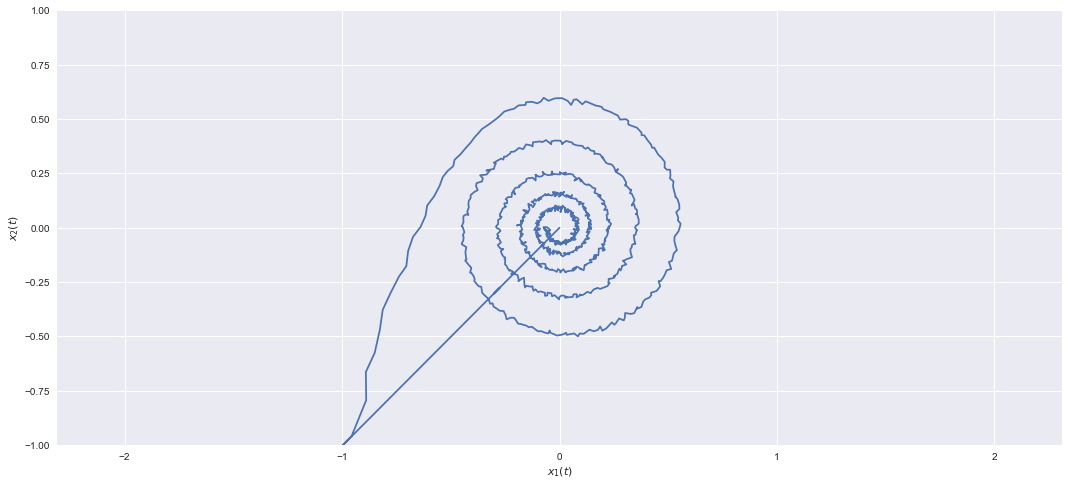

In [22]:
with nengolib.Network() as model:
    stim = nengo.Node(output=lambda t: 100*int(t < .01))
    sys = nengolib.networks.LinearNetwork(
        sys=nengolib.synapses.Bandpass(freq=5, Q=10),
        n_neurons_per_ensemble=500,
        synapse=.1, dt=1e-3, realizer=nengolib.signal.Balanced())
    nengo.Connection(stim, sys.input, synapse=None)
    p = nengo.Probe(sys.state.output, synapse=.01)

with nengo.Simulator(model, dt=sys.dt) as sim:
    sim.run(1.)

plt.figure(figsize=(18, 8))
plt.plot(*sim.data[p].T)
plt.xlabel("$x_1(t)$")
plt.ylabel("$x_2(t)$")
plt.axis('equal')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()

To bring things full circle, [`nengolib.networks.RollingWindow`](https://arvoelke.github.io/nengolib-docs/nengolib.networks.RollingWindow.html#nengolib.networks.RollingWindow) applies almost everything we've seen thus far, by deriving this class with [`sys=nengolib.synapses.PadeDelay`](https://arvoelke.github.io/nengolib-docs/nengolib.synapses.PadeDelay.html).

In [23]:
with nengolib.Network() as model:
    process = nengo.processes.WhiteSignal(100., high=25, y0=0)
    stim = nengo.Node(output=process)
    rw = nengolib.networks.RollingWindow(
        theta=.05, n_neurons=2500, process=process,
        neuron_type=nengo.LIFRate(),
        realizer=nengolib.signal.Hankel())

    nengo.Connection(stim, rw.input, synapse=None)
    p_stim = nengo.Probe(stim)
    p_delay = nengo.Probe(rw.output)
    p_max = nengo.Probe(rw.add_output(function=np.max))
    p_window = nengo.Probe(rw.add_output(function=lambda w: w[::20]))

with nengo.Simulator(model, seed=0) as sim:
    sim.run(.5)

c:\Users\Aaron\Anaconda2\lib\site-packages\scipy\signal\filter_design.py:1057: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)
c:\users\aaron\ctn\nengolib\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)


Building finished in 0:00:13.                                                   
Simulating finished in 0:00:01.                                                 


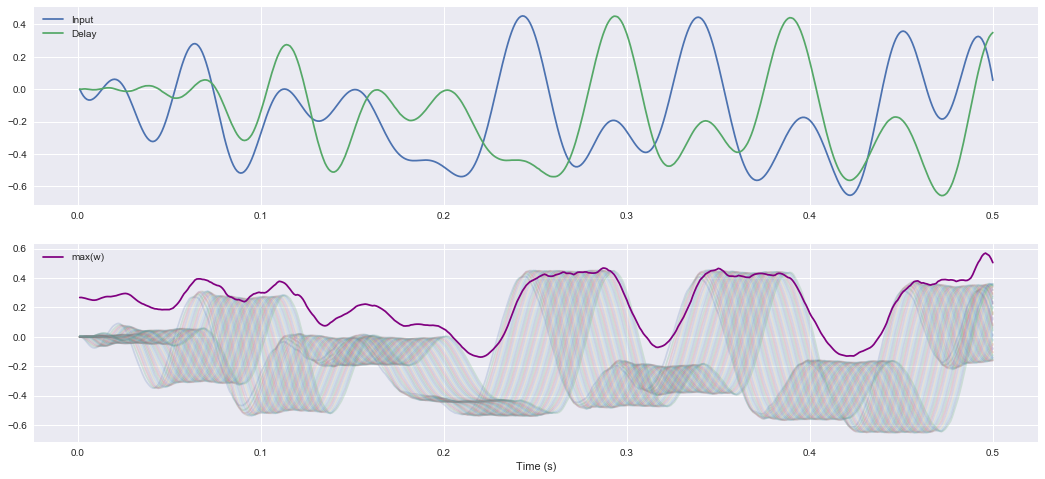

In [24]:
fig, ax = plt.subplots(2, 1, figsize=(18, 8))
ax[0].plot(sim.trange(), sim.data[p_stim], label="Input")
ax[0].plot(sim.trange(), sim.data[p_delay], label="Delay")
ax[0].legend()
ax[1].plot(sim.trange(), sim.data[p_window], alpha=.2)
ax[1].plot(sim.trange(), sim.data[p_max], c='purple', label="max(w)")
ax[1].legend()
ax[1].set_xlabel("Time (s)")
fig.show()

We can also visualize the temporal basis functions of the delay network, according to its chosen state-space realization.

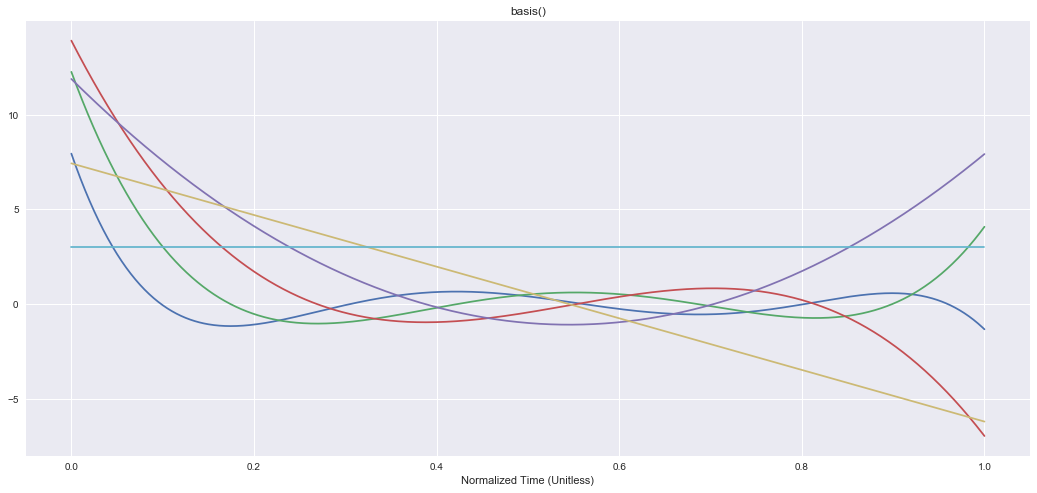

In [25]:
plt.figure(figsize=(18, 8))
plt.title("basis()")
plt.plot(nengolib.networks.t_default, rw.basis())
plt.xlabel("Normalized Time (Unitless)")
plt.show()

## 7) PES Learning Rates

Usually the PES rule is applied by choosing some arbitrary learning rate, which is then manually increased or decreased depending on whether it's too slow (not converging) or it's  too fast (oscillating). But, since we understand the dynamics of the PES rule, we can take a more principled approach to set the learning rate.

The theory behind [A Solution to the Dynamics of the Prescribed Error Sensitivity Learning Rule](http://compneuro.uwaterloo.ca/publications/voelker2015.html) is used by [`nengolib.signal.pes_learning_rate`](https://arvoelke.github.io/nengolib-docs/nengolib.signal.pes_learning_rate.html#nengolib.signal.pes_learning_rate) to set the learning rate for PES. This theory is improved in [Analysis of oscillatory weight changes from online learning with filtered spiking feedback](http://compneuro.uwaterloo.ca/publications/voelker2017c.html), but not yet a part of the library.